In [1]:
import numpy as np
import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.risk as risk
import mlgrad.avragg as avragg
# import mlgrad.gd as gd
import mlgrad.regnorm as regnorm
import mlgrad.weights as weights
from mlgrad.utils import array_exclude_outliers

import mlgrad.regr as regr

from mlgrad import averager_it, averager_fg, fg, erm_fg, sg, erm_sg, irgd, erm_irgd, erisk, mrisk

#import sklearn.linear_model as sklm

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-ticks'])

import sys
print(sys.version)

3.9.2 (default, Feb 28 2021, 17:03:44) 
[GCC 10.2.1 20210110]


In [2]:
df = pd.read_csv("data/starsCYG.csv", sep=',', usecols=["log.Te", "log.light"], )

In [3]:
len(df)

47

In [6]:
Y = df["log.light"].values
X = df["log.Te"].values

X -= np.median(X)
Y -= np.median(Y)


# x_min, x_max = X.min(), X.max()
# X = (X - x_min) / (x_max - x_min)
# y_min, y_max = Y.min(), Y.max()
# Y = (Y - y_min) / (y_max - y_min)

Xs = X.reshape((-1,1))

X0 = np.linspace(X.min(), X.max(), 20)

In [7]:
from sklearn.preprocessing import scale

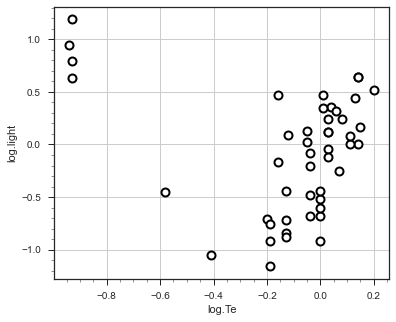

In [8]:
plt.figure(figsize=(6.0, 5.0))
plt.scatter(X, Y, s=64, c='w', edgecolors='k', linewidths=2.)
plt.minorticks_on()
plt.grid(1)
plt.xlabel('log.Te')
plt.ylabel('log.light')
# plt.xlim(-0.9, 0.6)
# plt.ylim(-2.5, 2.0)
plt.show()

In [9]:
loss_func_sq = loss.ErrorLoss(func.Square())
# loss_func_rsq = loss.RelativeErrorLoss(func.Square())
loss_func_abs = loss.ErrorLoss(func.Absolute())

In [10]:
sqr_norm = regnorm.SquareNorm()

In [11]:
def curve_fit_and_errors(alg):
    err = np.abs(Y - alg.risk.model.evaluate_all(Xs))
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.title('Fit curve')
    plt.plot(alg.lvals)
    plt.xlabel('step')
    plt.ylabel('mean of errors')
    plt.minorticks_on()
    plt.subplot(1,2,2)
    plt.title('Errors')
    plt.plot(sorted(err), marker='s', markersize='6')
    plt.minorticks_on()
    plt.xlabel('error rank')
    plt.ylabel('error value')
    plt.show()
    return err

In [13]:
mod_ls = model.LinearModel(1)
mod_ls.init()

K=1000 param=[-0.13298676 -0.41073491]


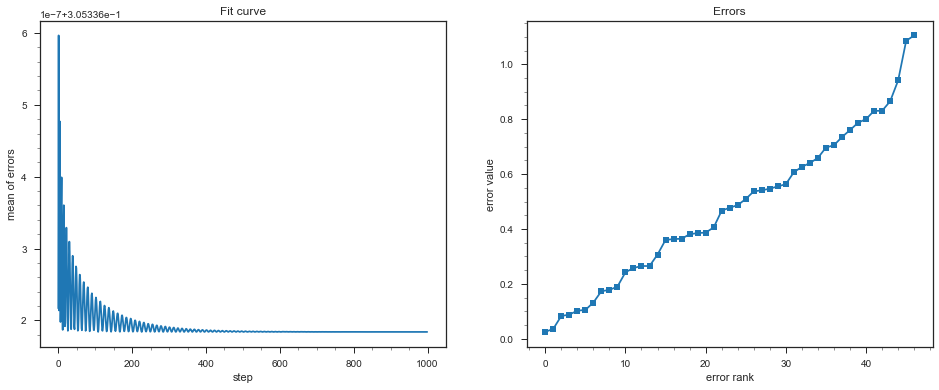

In [16]:
alg_ls = regr.regression(Xs, Y, mod_ls, verbose=1)
err_ls = curve_fit_and_errors(alg_ls)

In [18]:
mod_m_irls = model.LinearModel(1)
mod_m_irls.init()

K=70 param=[-0.01142443  1.0954347 ]


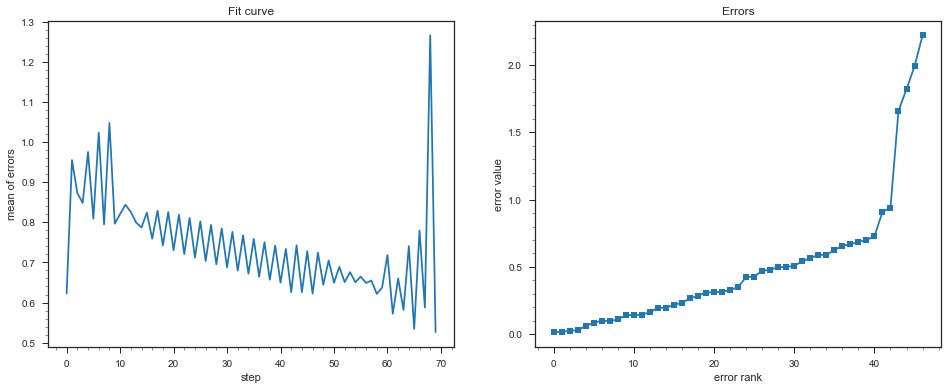

In [19]:
avg_m_irls = regr.averaging_function('M', rhofunc=func.Quantile_Sqrt(0.86, 0.001))
alg_m_irls = regr.m_regression_irls(Xs, Y, mod_m_irls, avrfunc=avg_m_irls, h=0.001, n_iter2=70, verbose=1)
err_m_irls = curve_fit_and_errors(alg_m_irls)

In [21]:
mod_wm_irls = model.LinearModel(1)
mod_wm_irls.init()

K=10 param=[-0.23933662  2.82234101]


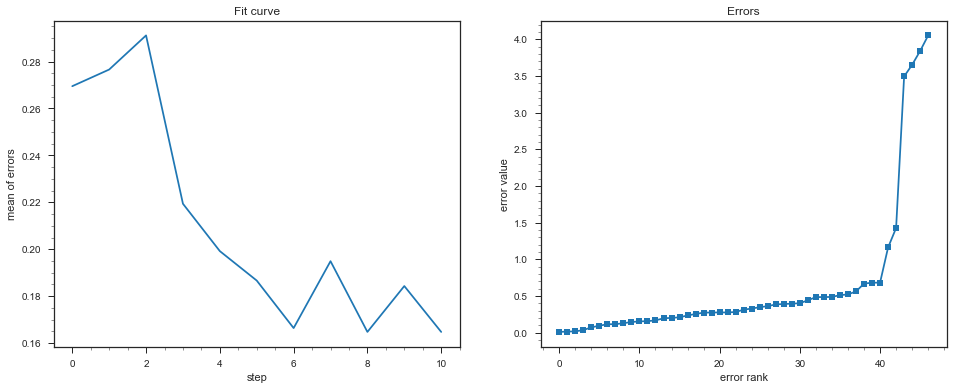

In [22]:
avg_wm_irls = regr.averaging_function('WM', rhofunc=func.Quantile_Sqrt(0.86, 0.001))
alg_wm_irls = regr.m_regression_irls(Xs, Y, mod_wm_irls, avrfunc=avg_wm_irls, h=0.001, n_iter2=70, verbose=1)
err_wm_irls = curve_fit_and_errors(alg_wm_irls)

In [25]:
mod_swm_irls = model.LinearModel(1)
mod_swm_irls.init()

K=8 param=[-0.23935432  2.82283474]


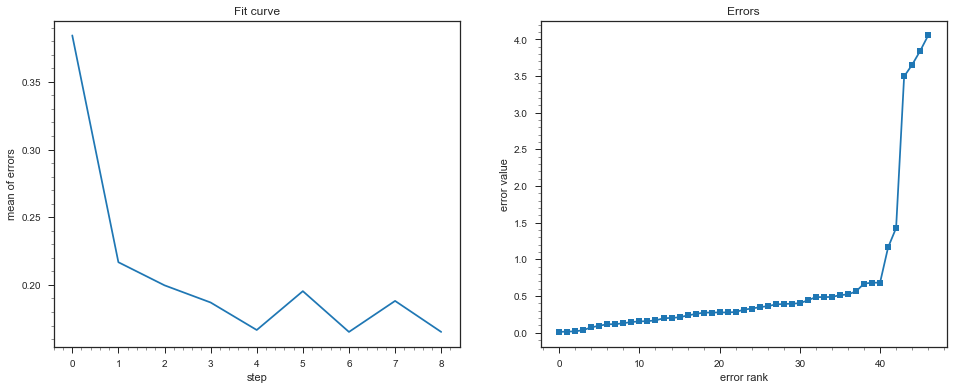

In [26]:
avg_swm_irls = regr.averaging_function('SWM', rhofunc=func.QuantileFunc(0.86, func.Sqrt(0.001)), 
                                       absfunc=func.Sqrt(0.001))
alg_swm_irls = regr.m_regression_irls(Xs, Y, mod_swm_irls, avrfunc=avg_swm_irls, h=0.001, tol=1.0e-8, verbose=1)
err_swm_irls = curve_fit_and_errors(alg_swm_irls)

In [32]:
# Err = np.abs(Y - mod2.evaluate_all(Xs))

# X1, X1_ = array_exclude_outliers(X, Err, 7) 
# Y1, Y1_ = array_exclude_outliers(Y, Err, 7) 
# X1s = X1.reshape(-1,1)

In [28]:
mod_r_irls = model.LinearModel(1)
mod_r_irls.init()

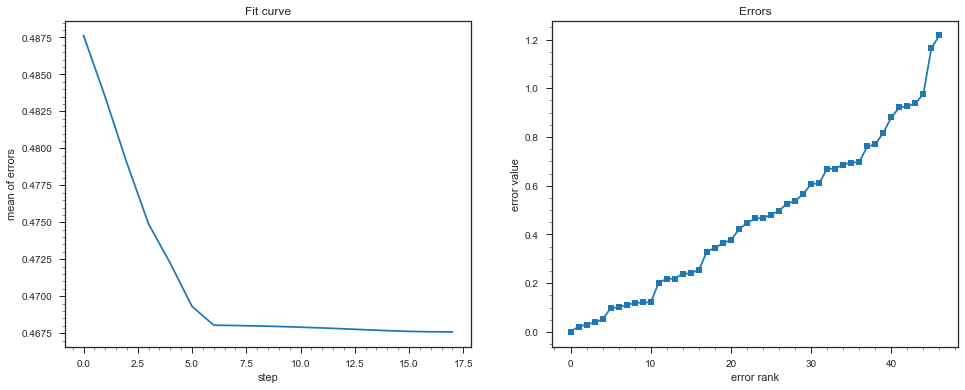

In [29]:
alg_r_irls = regr.r_regression_irls(Xs, Y, mod_r_irls, rhofunc=func.Sqrt(0.001))
err_r_irls = curve_fit_and_errors(alg_r_irls)

In [35]:
# mod_wm_ls = model.LinearModel(1)
# mod_wm_ls.init()

In [36]:
# avg_wm_ls = regr.averaging_function('WM', rhofunc=func.Quantile_Sqrt(0.84, 0.001))
# alg_wm_ls = regr.m_regression(Xs, Y, mod_wm_ls, avrfunc=avg_wm_ls, h=0.1, tol=1.0e-8)
# err_wm_ls = curve_fit_and_errors(alg_wm_ls)

In [37]:
# mod_hm_irls = model.LinearModel(1)
# mod_hm_irls.init()

In [38]:
# avg_hm_irls = regr.averaging_function('HM', rhofunc=func.Quantile_Sqrt(0.85, 0.001))
# alg_hm_irls = regr.m_regression_irls(Xs, Y, mod_hm_irls, avrfunc=avg_hm_irls, h=0.001, tol=1.0e-9, n_iter2=22, tol2=1.0e-8)
# err_hm_irls = curve_fit_and_errors(alg_hm_irls)

[-0.38031337  0.15577589 -0.69068084  0.15577589 -0.57781995 -0.12637635
 -1.87572028  0.18399112 -0.69068084 -0.38031337 -2.86325314 -0.21102203
 -0.0699459  -1.39606146 -0.60603517 -0.23923725 -0.77532652 -0.23923725
 -0.77532652 -2.86325314 -0.60603517 -0.60603517 -0.23923725 -0.04173068
 -0.35209815 -0.23923725 -0.60603517 -0.35209815 -0.80354174 -2.89146836
 -0.35209815  0.15577589 -0.15459158 -2.86325314 -0.77532652  0.32506724
  0.07113022 -0.15459158  0.07113022 -0.21102203 -0.35209815 -0.15459158
 -0.01351546 -0.15459158  0.12756067 -0.15459158 -0.23923725]


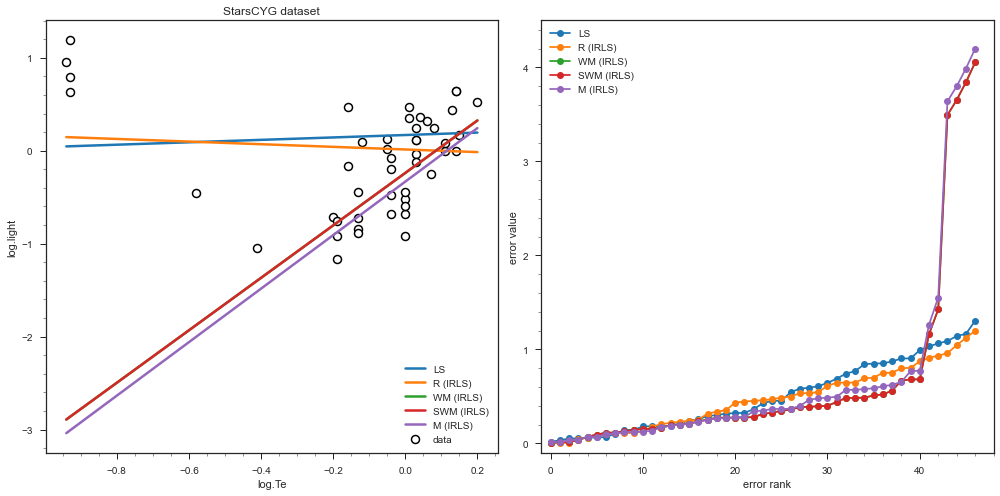

In [39]:
plt.figure(figsize=(14.0, 7.0))
plt.subplot(1,2,1)
plt.title('StarsCYG dataset')
plt.scatter(X, Y, s=64, c='w', edgecolors='k', linewidths=1.5, label='data')
plt.plot(X0, mod_ls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'LS')
plt.plot(X0, mod_r_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'R (IRLS)')
plt.plot(X0, mod_wm_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'WM (IRLS)')
# plt.plot(X0, mod_wm_ls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'WM (LS)')
plt.plot(X0, mod_swm_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'SWM (IRLS)')
plt.plot(X0, mod_m_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'M (IRLS)')
print(mod_swm_irls.evaluate_all(Xs))
plt.minorticks_on()
# plt.grid(1)
plt.xlabel('log.Te')
plt.ylabel('log.light')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(sorted(np.abs(Y - mod_ls.evaluate_all(Xs))), marker='o', markersize=7, label=r'LS')
plt.plot(sorted(np.abs(Y - mod_r_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'R (IRLS)')
plt.plot(sorted(np.abs(Y - mod_wm_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'WM (IRLS)')
# plt.plot(sorted(np.abs(Y - mod_wm_ls.evaluate_all(Xs))), marker='o', markersize=7, label=r'WM (LS)')
plt.plot(sorted(np.abs(Y - mod_swm_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'SWM (IRLS)')
plt.plot(sorted(np.abs(Y - mod_m_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'M (IRLS)')
plt.minorticks_on()
# plt.grid(1)
plt.ylabel('error value')
plt.xlabel('error rank')
plt.ylim(-0.1, 4.5)
plt.xlim(-1, 48)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [25]:
41/47

0.8723404255319149